# Machine Learning models on Mismatch Response data

In this notebook: 
- Necessary imports
- SVM model 
- Logistic Regression model
- Decision Tree model

## Imports

In [1]:
import os       # using operating system dependent functionality (folders)
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
import seaborn as sn
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../eegyolk') # path to helper functions
import helper_functions as hf # library useful for eeg and erp data cleaning
import epod_helper

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 

In [2]:
df = pd.read_csv('df_avg_mmr.csv', sep = ',')
df.head()

,Group_AccToParents,std_AF4,std_FC5,std_O1,std_PO4,std_Pz,sur_AF4,sur_FC5,sur_O1,sur_PO4,...,min_Pz,max_AF4,max_FC5,max_O1,max_PO4,max_Pz,ParticipantID,test,sex,age_months
0,1,0.000001,1.019953e-06,0.000002,0.000002,0.000001,-0.002290,-0.001389,-0.001222,-0.004980,...,-0.000005,0.000002,0.000001,0.000003,0.000001,9.479040e-07,101,a,1,20
1,1,0.000002,2.198310e-06,0.000016,0.000003,0.000003,-0.000986,-0.003107,0.033049,0.007922,...,-0.000002,0.000003,0.000003,0.000043,0.000010,9.259968e-06,103,a,0,20
2,1,0.000001,7.629572e-07,0.000001,0.000002,0.000001,-0.001301,-0.000635,0.001034,0.000391,...,-0.000003,0.000002,0.000002,0.000004,0.000004,2.285211e-06,104,a,1,18
3,1,0.000004,2.365847e-06,0.000003,0.000001,0.000001,0.006662,0.004263,0.008843,-0.001303,...,-0.000001,0.000012,0.000009,0.000009,0.000002,2.689267e-06,105,a,0,17
4,0,0.000002,1.672483e-06,0.000002,0.000002,0.000001,-0.000429,-0.003228,0.000640,0.001983,...,-0.000001,0.000003,0.000002,0.000006,0.000007,4.757814e-06,106,a,1,19


In [3]:
dfcor = df.corr()

In [4]:
dfcor

,Group_AccToParents,std_AF4,std_FC5,std_O1,std_PO4,std_Pz,sur_AF4,sur_FC5,sur_O1,sur_PO4,...,min_PO4,min_Pz,max_AF4,max_FC5,max_O1,max_PO4,max_Pz,ParticipantID,sex,age_months
Group_AccToParents,1.000000,0.113331,-0.194020,0.167952,0.202560,0.175488,0.222574,0.211188,0.119911,0.134901,...,-0.032421,0.024676,0.264299,0.037364,0.186655,0.205919,0.104989,-0.179183,-0.125751,0.056963
std_AF4,0.113331,1.000000,0.569919,0.249322,0.456250,0.255249,-0.026736,-0.063640,0.045203,-0.150305,...,-0.330596,-0.119295,0.586651,0.384446,0.243992,0.156942,0.166506,-0.022457,-0.173474,-0.018364
std_FC5,-0.194020,0.569919,1.000000,0.125497,0.211688,0.350651,-0.216218,-0.418392,0.178924,0.004421,...,-0.090146,-0.233700,0.186683,0.337689,0.196349,0.144628,0.240425,-0.070729,-0.143108,0.162388
std_O1,0.167952,0.249322,0.125497,1.000000,0.542458,0.280370,0.120088,-0.044708,0.173378,0.081115,...,-0.220800,0.044582,0.280854,-0.000968,0.891982,0.504172,0.280900,-0.147784,-0.154512,-0.053243
std_PO4,0.202560,0.456250,0.211688,0.542458,1.000000,0.429463,-0.043960,-0.146625,0.065738,-0.062502,...,-0.616463,-0.204591,0.271705,-0.029627,0.482848,0.523471,0.229165,0.123857,-0.186028,0.069905
std_Pz,0.175488,0.255249,0.350651,0.280370,0.429463,1.000000,-0.023730,-0.143024,0.431837,0.180936,...,-0.020470,-0.266277,0.146527,0.075262,0.413195,0.351825,0.692582,0.061860,-0.105194,0.178925
sur_AF4,0.222574,-0.026736,-0.216218,0.120088,-0.043960,-0.023730,1.000000,0.661329,0.226433,0.289806,...,0.204939,0.385086,0.720715,0.418673,0.212129,0.167775,0.257150,0.062838,0.066664,-0.075940
sur_FC5,0.211188,-0.063640,-0.418392,-0.044708,-0.146625,-0.143024,0.661329,1.000000,0.241644,0.295152,...,0.249573,0.296361,0.420922,0.576363,0.084394,0.082045,0.052622,0.112534,-0.010386,-0.182158
sur_O1,0.119911,0.045203,0.178924,0.173378,0.065738,0.431837,0.226433,0.241644,1.000000,0.573647,...,0.418362,0.157309,0.144534,0.257125,0.576176,0.362917,0.496318,-0.109024,-0.013550,0.169952
sur_PO4,0.134901,-0.150305,0.004421,0.081115,-0.062502,0.180936,0.289806,0.295152,0.573647,1.000000,...,0.625260,0.380053,0.092975,0.196023,0.330429,0.718172,0.505172,-0.118851,0.051309,0.073801


In [5]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(dfcor, 50))

Top Absolute Correlations
std_O1   max_O1        0.943107
sur_FC5  min_FC5       0.933901
std_FC5  min_FC5       0.913600
min_AF4  min_FC5       0.910997
std_O1   min_O1        0.887300
sur_AF4  min_AF4       0.863896
         sur_FC5       0.857722
sur_FC5  min_AF4       0.841749
std_FC5  min_AF4       0.841070
max_O1   max_PO4       0.837608
sur_Pz   max_Pz        0.833133
std_PO4  min_PO4       0.829128
sur_PO4  sur_Pz        0.809090
std_PO4  min_O1        0.800579
std_O1   std_PO4       0.797405
std_AF4  std_FC5       0.786189
sur_AF4  min_FC5       0.772455
max_PO4  max_Pz        0.758061
std_Pz   max_Pz        0.743782
std_O1   max_PO4       0.743515
sur_PO4  min_PO4       0.741549
std_FC5  sur_FC5       0.740207
min_AF4  min_Pz        0.734983
sur_O1   sur_PO4       0.734622
min_PO4  min_Pz        0.732379
min_O1   min_PO4       0.730094
std_AF4  min_AF4       0.719456
         std_PO4       0.714334
std_Pz   min_FC5       0.709785
std_AF4  min_PO4       0.705680
std_PO4  max_O

## Split data

In [6]:
y = df['Group_AccToParents'].values # dependent variable
X = df.drop(['Group_AccToParents','ParticipantID', 'test',
       'sex', 'age_months'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [7]:
X.columns

Index(['std_AF4', 'std_FC5', 'std_O1', 'std_PO4', 'std_Pz', 'sur_AF4',
       'sur_FC5', 'sur_O1', 'sur_PO4', 'sur_Pz', 'min_AF4', 'min_FC5',
       'min_O1', 'min_PO4', 'min_Pz', 'max_AF4', 'max_FC5', 'max_O1',
       'max_PO4', 'max_Pz'],
      dtype='object')

## Scale data

In [8]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

## SVM model

In [9]:
svm = SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':[0.001, 1]}
clf = GridSearchCV(svm, parameters)
clf.fit(X_train, y_train)

sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [10]:
clf.best_params_

{'C': 0.001, 'kernel': 'linear'}

In [11]:
clf.score(X_train, y_train)

0.6166666666666667

In [12]:
svm = SVC(C=1, kernel='linear', random_state=False)
svm.fit(X_train, y_train)

SVC(C=1, kernel='linear', random_state=False)

In [13]:
y_pred = svm.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.610


In [14]:
y_pred

array([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

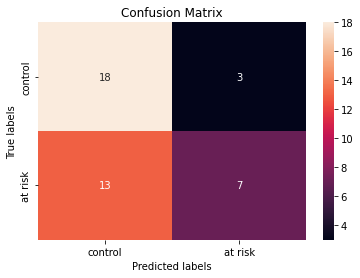

In [15]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

In [16]:
# with kfold cross validation
k = 6
kf = KFold(n_splits=k, shuffle=True, random_state=None)
model = svm
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [0.5882352941176471, 0.6470588235294118, 0.35294117647058826, 0.6470588235294118, 0.6470588235294118, 0.5625]
Avg accuracy : 0.5741421568627451


## Logistic Regression model

In [17]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [18]:
y_pred = lr.predict(X_test)

In [19]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.562


In [20]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

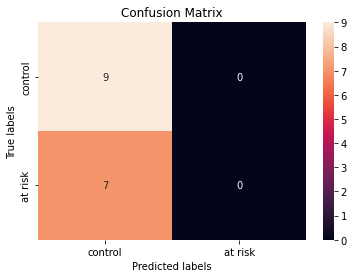

In [21]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

In [22]:
# with kfold cross validation
k = 6
kf = KFold(n_splits=k, shuffle = True, random_state=None)
model = lr
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [0.6470588235294118, 0.5882352941176471, 0.35294117647058826, 0.7058823529411765, 0.7058823529411765, 0.4375]
Avg accuracy : 0.5729166666666667


## Decision Tree model

In [23]:
dt = tree.DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [24]:
y_pred = dt.predict(X_test)

In [25]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.688


In [26]:
y_pred

array([0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1])

[Text(0.6666666666666666, 0.9166666666666666, 'X[5] <= 0.003\ngini = 0.48\nsamples = 85\nvalue = [51, 34]'),
 Text(0.6, 0.75, 'X[4] <= 0.0\ngini = 0.462\nsamples = 80\nvalue = [51, 29]'),
 Text(0.3333333333333333, 0.5833333333333334, 'X[6] <= -0.002\ngini = 0.431\nsamples = 70\nvalue = [48, 22]'),
 Text(0.13333333333333333, 0.4166666666666667, 'X[17] <= 0.0\ngini = 0.252\nsamples = 27\nvalue = [23, 4]'),
 Text(0.06666666666666667, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.2, 0.25, 'X[2] <= 0.0\ngini = 0.204\nsamples = 26\nvalue = [23, 3]'),
 Text(0.13333333333333333, 0.08333333333333333, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.26666666666666666, 0.08333333333333333, 'gini = 0.147\nsamples = 25\nvalue = [23, 2]'),
 Text(0.5333333333333333, 0.4166666666666667, 'X[16] <= 0.0\ngini = 0.487\nsamples = 43\nvalue = [25, 18]'),
 Text(0.4666666666666667, 0.25, 'X[3] <= 0.0\ngini = 0.5\nsamples = 36\nvalue = [18, 18]'),
 Text(0.4, 0.08333333333333333, 'gini = 0.496\ns

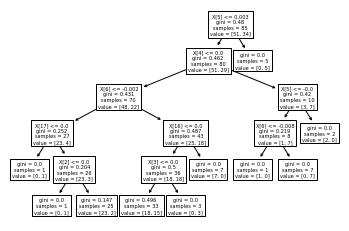

In [27]:
tree.plot_tree(dt)

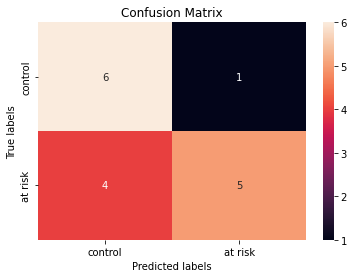

In [28]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

In [29]:
# with kfold cross validation
k = 6
kf = KFold(n_splits=k, shuffle=True, random_state=None)
model = tree.DecisionTreeClassifier(max_depth=5)
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [0.5294117647058824, 0.4117647058823529, 0.29411764705882354, 0.29411764705882354, 0.4117647058823529, 0.25]
Avg accuracy : 0.3651960784313726


## CNN